# Rings Profile
This notebook contains code to analyze the rings data, in order to check if the data is in order and its distributions.

In [1]:
from lzt_utils.dataset import LztDataset
from lzt_utils.constants import N_RINGS
from lzt_utils.utils import set_logger
import lzt_utils.plotting.pyplot as lplt
import mplhep
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import ROOT
import numpy as np
import pandas as pd
import logging
from tqdm import tqdm


Module libc not found.


In [2]:
ROOT.EnableImplicitMT()
plt.style.use(mplhep.style.ATLAS)
set_logger()
mpl.rc('text', usetex = True)

# Load data

In [3]:
lzt_data = Path.home() / 'ext_data' / 'lorenzetti'
output_dir = lzt_data / 'profiles' / 'boosted-lorenzetti-2025-04-18'
output_dir.mkdir(exist_ok=True, parents=True)
datasets = {}
datasets['zee'] = {
    'ds': LztDataset.from_dir(
        lzt_data / 'v2.1.0' / 'user.joao.pinto.mc25_13TeV.250401.Pythia8EvtGen_Zee'
    ),
    'color': 'blue',
    'label': '$Z \\to ee$',
}

datasets['jf17'] = {
    'ds': LztDataset.from_dir(
        lzt_data / 'v2.1.0' / 'user.joao.pinto.mc25_13TeV.250401.Pythia8EvtGen_JF17'
    ),
    'color': 'red',
    'label': 'Jets w/ $E \\geq 17 \\: GeV$'
}

datasets

{'zee': {'ds': LztDataset(path=/root/ext_data/lorenzetti/v2.1.0/user.joao.pinto.mc25_13TeV.250401.Pythia8EvtGen_Zee, label=Z->ee),
  'color': 'blue',
  'label': '$Z \\to ee$'},
 'jf17': {'ds': LztDataset(path=/root/ext_data/lorenzetti/v2.1.0/user.joao.pinto.mc25_13TeV.250401.Pythia8EvtGen_JF17, label=Jets et > 17GeV),
  'color': 'red',
  'label': 'Jets w/ $E \\geq 17 \\: GeV$'}}

In [4]:
def load_data_from_aod(dataset: LztDataset, n_entries: int = -1) -> pd.DataFrame:
    rings_info = []
    iterator = tqdm(enumerate(dataset.aod_tchain),
                    desc='Processing events', unit=' events')
    if n_entries < 0:
        n_entries = np.inf
    for entry, aod_event in iterator:
        if entry >= n_entries:
            break
        event_number = aod_event.EventInfoContainer_Events[0].eventNumber
        for iring, rings_data in enumerate(aod_event.CaloRingsContainer_Rings):
            if rings_data.cluster_link >= len(aod_event.CaloClusterContainer_Clusters):
                logging.warning(f'{entry} - Event {event_number} - '
                                f'iring {iring} - Cluster link {rings_data.cluster_link} out of range')
                continue
            cluster_data = aod_event.CaloClusterContainer_Clusters[rings_data.cluster_link]
            record = {
                'event_number': event_number,
                'rings_size': len(rings_data.rings),
                'cl_eta': cluster_data.eta,
                'cl_phi': cluster_data.phi,
            }
            for i, ring in enumerate(rings_data.rings):
                record[f'ring_{i}'] = ring
            rings_info.append(record)
    rings_info = pd.DataFrame.from_dict(rings_info)
    return rings_info

In [5]:
def load_data_from_ntuple(dataset: LztDataset, n_entries: int = -1) -> pd.DataFrame:
    rings_info = []
    iterator = tqdm(enumerate(dataset.ntuple_tchain))
    if n_entries < 0:
        n_entries = np.inf
    for entry, event in iterator:
        if entry >= n_entries:
            break
        record = {
            'event_number': event.EventNumber,
            'rings_size': len(event.cl_rings),
            'cl_eta': event.cl_eta,
            'cl_phi': event.cl_phi,
        }
        for i, ring in enumerate(event.cl_rings):
            record[f'ring_{i}'] = ring
        rings_info.append(record)
    rings_info = pd.DataFrame.from_dict(rings_info)
    return rings_info

In [6]:
data_src = 'aod'
rewrite_cache = False
n_entries = -1
for name, dataset_info in datasets.items():
    output_filepath = output_dir / f'rings_info_{name}_{data_src}.parquet.gzip'
    if not rewrite_cache and output_filepath.exists():
        logging.info(f'Loading cached file for {name}')
        rings_info = pd.read_parquet(output_filepath)
    else:
        logging.info(f'Loading {name}')
        if data_src =='aod':
            rings_info = load_data_from_aod(dataset_info['ds'], n_entries)
        elif data_src == 'ntuple':
            rings_info = load_data_from_ntuple(dataset_info['ds'], n_entries)
        else:
            raise ValueError(f"Unknown data source: {data_src}")
        logging.info('Writing rings_info to parquet')
        rings_info.to_parquet(output_filepath,
                              compression='gzip')
    datasets[name]['rings_info'] = rings_info

2025-05-02 14:24:45 | INFO | root | 3318279325 | 10 | Loading zee


Processing events: 1460 events [00:29, 46.54 events/s]

2025-05-02 14:25:15 | WARNING | root | 758006356 | 13 | 1462 - Event 1304.0 - iring 0 - Cluster link 1 out of range


Processing events: 10000 events [03:26, 48.33 events/s]


2025-05-02 14:28:13 | INFO | root | 3318279325 | 17 | Writing rings_info to parquet
2025-05-02 14:28:14 | INFO | root | 3318279325 | 10 | Loading jf17


Processing events: 212 events [00:06, 33.53 events/s]

2025-05-02 14:28:20 | WARNING | root | 758006356 | 13 | 214 - Event 34.0 - iring 1 - Cluster link 2 out of range


Processing events: 807 events [00:23, 36.70 events/s]

2025-05-02 14:28:38 | WARNING | root | 758006356 | 13 | 807 - Event 1163.0 - iring 2 - Cluster link 3 out of range


Processing events: 1288 events [00:38, 48.91 events/s]

2025-05-02 14:28:53 | WARNING | root | 758006356 | 13 | 1290 - Event 1185.0 - iring 0 - Cluster link 1 out of range


Processing events: 1504 events [00:47, 28.15 events/s]

2025-05-02 14:29:01 | WARNING | root | 758006356 | 13 | 1511 - Event 2004.0 - iring 1 - Cluster link 2 out of range


Processing events: 1817 events [00:57, 40.66 events/s]

2025-05-02 14:29:12 | WARNING | root | 758006356 | 13 | 1817 - Event 1909.0 - iring 0 - Cluster link 1 out of range


Processing events: 1907 events [01:00, 40.18 events/s]

2025-05-02 14:29:14 | WARNING | root | 758006356 | 13 | 1911 - Event 1698.0 - iring 1 - Cluster link 2 out of range


Processing events: 1969 events [01:02, 43.13 events/s]

2025-05-02 14:29:16 | WARNING | root | 758006356 | 13 | 1972 - Event 1892.0 - iring 1 - Cluster link 2 out of range


Processing events: 2324 events [01:11, 45.54 events/s]

2025-05-02 14:29:26 | WARNING | root | 758006356 | 13 | 2327 - Event 2501.0 - iring 1 - Cluster link 2 out of range


Processing events: 2913 events [01:29, 32.72 events/s]

2025-05-02 14:29:44 | WARNING | root | 758006356 | 13 | 2917 - Event 2549.0 - iring 1 - Cluster link 3 out of range


Processing events: 3157 events [01:37, 28.05 events/s]

2025-05-02 14:29:51 | WARNING | root | 758006356 | 13 | 3160 - Event 3106.0 - iring 2 - Cluster link 4 out of range


Processing events: 3794 events [01:57, 34.51 events/s]

2025-05-02 14:30:12 | WARNING | root | 758006356 | 13 | 3796 - Event 3976.0 - iring 2 - Cluster link 4 out of range


Processing events: 3978 events [02:06, 19.32 events/s]

2025-05-02 14:30:20 | WARNING | root | 758006356 | 13 | 3980 - Event 3771.0 - iring 0 - Cluster link 1 out of range


Processing events: 4214 events [02:12, 32.54 events/s]

2025-05-02 14:30:27 | WARNING | root | 758006356 | 13 | 4223 - Event 4561.0 - iring 0 - Cluster link 1 out of range


Processing events: 4225 events [02:12, 43.41 events/s]

2025-05-02 14:30:27 | WARNING | root | 758006356 | 13 | 4227 - Event 3876.0 - iring 2 - Cluster link 3 out of range


Processing events: 5143 events [02:39, 39.92 events/s]

2025-05-02 14:30:54 | WARNING | root | 758006356 | 13 | 5144 - Event 5031.0 - iring 1 - Cluster link 2 out of range


Processing events: 5484 events [02:50, 31.38 events/s]

2025-05-02 14:31:04 | WARNING | root | 758006356 | 13 | 5484 - Event 5262.0 - iring 1 - Cluster link 3 out of range


Processing events: 6286 events [03:13, 26.33 events/s]

2025-05-02 14:31:27 | WARNING | root | 758006356 | 13 | 6290 - Event 6319.0 - iring 1 - Cluster link 2 out of range


Processing events: 7008 events [03:34, 25.52 events/s]

2025-05-02 14:31:48 | WARNING | root | 758006356 | 13 | 7015 - Event 7147.0 - iring 0 - Cluster link 1 out of range


Processing events: 7401 events [03:46, 25.77 events/s]

2025-05-02 14:32:01 | WARNING | root | 758006356 | 13 | 7407 - Event 7193.0 - iring 1 - Cluster link 2 out of range


Processing events: 7854 events [04:01, 20.20 events/s]

2025-05-02 14:32:15 | WARNING | root | 758006356 | 13 | 7855 - Event 7817.0 - iring 0 - Cluster link 1 out of range


Processing events: 7862 events [04:01, 18.22 events/s]

2025-05-02 14:32:16 | WARNING | root | 758006356 | 13 | 7868 - Event 7818.0 - iring 2 - Cluster link 3 out of range


Processing events: 7998 events [04:06, 32.90 events/s]

2025-05-02 14:32:21 | WARNING | root | 758006356 | 13 | 8001 - Event 8236.0 - iring 2 - Cluster link 4 out of range


Processing events: 8146 events [04:11, 33.35 events/s]

2025-05-02 14:32:25 | WARNING | root | 758006356 | 13 | 8147 - Event 8201.0 - iring 1 - Cluster link 2 out of range


Processing events: 8272 events [04:15, 39.04 events/s]

2025-05-02 14:32:30 | WARNING | root | 758006356 | 13 | 8275 - Event 8052.0 - iring 2 - Cluster link 3 out of range


Processing events: 8441 events [04:21, 37.63 events/s]

2025-05-02 14:32:35 | WARNING | root | 758006356 | 13 | 8443 - Event 8402.0 - iring 1 - Cluster link 2 out of range


Processing events: 8975 events [04:39, 33.94 events/s]

2025-05-02 14:32:53 | WARNING | root | 758006356 | 13 | 8977 - Event 8828.0 - iring 1 - Cluster link 2 out of range


Processing events: 9479 events [04:56, 26.65 events/s]

2025-05-02 14:33:10 | WARNING | root | 758006356 | 13 | 9483 - Event 9411.0 - iring 1 - Cluster link 3 out of range


Processing events: 9829 events [05:10, 28.36 events/s]

2025-05-02 14:33:24 | WARNING | root | 758006356 | 13 | 9832 - Event 9796.0 - iring 2 - Cluster link 3 out of range


Processing events: 9842 events [05:10, 33.90 events/s]

2025-05-02 14:33:24 | WARNING | root | 758006356 | 13 | 9845 - Event 9786.0 - iring 0 - Cluster link 2 out of range


Processing events: 10000 events [05:15, 31.71 events/s]


2025-05-02 14:33:30 | INFO | root | 3318279325 | 17 | Writing rings_info to parquet


# Check number of vector entries

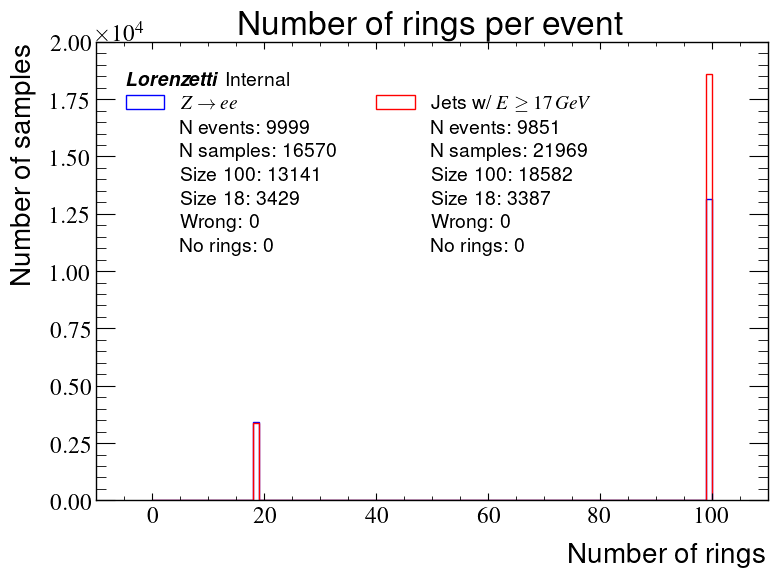

In [7]:
fig, ax = plt.subplots()
max_ring_size = -1
bins = np.arange(201)
for name, dataset_info in datasets.items():
    rings_info = dataset_info['rings_info']
    current_max_ring_size = rings_info['rings_size'].max()
    if current_max_ring_size > max_ring_size:
        max_ring_size = current_max_ring_size
    ax.hist(rings_info['rings_size'],
            bins=np.arange(current_max_ring_size + 1),
            histtype='step',
            color=dataset_info['color'],
            label=dataset_info['label'])
    # ax.grid(linestyle='--', alpha=0.5)
    ax.plot([], [], ' ',
        label=f'N events: {rings_info["event_number"].nunique()}')
    ax.plot([], [], ' ',
            label=f'N samples: {len(rings_info)}')
    has_100 = rings_info["rings_size"] == 100
    ax.plot([], [], ' ',
            label=f'Size 100: {has_100.sum()}')
    has_18 = rings_info["rings_size"] == 18
    ax.plot([], [], ' ',
            label=f'Size 18: {has_18.sum()}')
    ax.plot([], [], ' ',
            label=f'Wrong: {((~has_100) & (~has_18)).sum()}')
    ax.plot([], [], ' ',
            label=f'No rings: {(rings_info["rings_size"] == 0).sum()}')
    # ax.plot([], [], ' ',
    #         label=f'Extra: {(rings_info["rings_size"] > N_RINGS).sum()}')
    # ax.plot([], [], ' ',
    #         label=f'Missing: {(rings_info["rings_size"] < N_RINGS).sum()}')
ax.set(
    xlabel='Number of rings',
    ylabel='Number of samples',
    title='Number of rings per event',
    xlim=(-10, max_ring_size + 10)
)
ax.legend(title='\\textbf{{\\textit{{Lorenzetti}}}} Internal',
          alignment='left',
          facecolor='white',
          ncols=len(datasets),
          )
fig.tight_layout()
fig.savefig(output_dir / f'number_of_rings_{data_src}.png', dpi=300)

/tmp/ipykernel_65458/3547811672.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  lower_ax.legend(alignment='left',


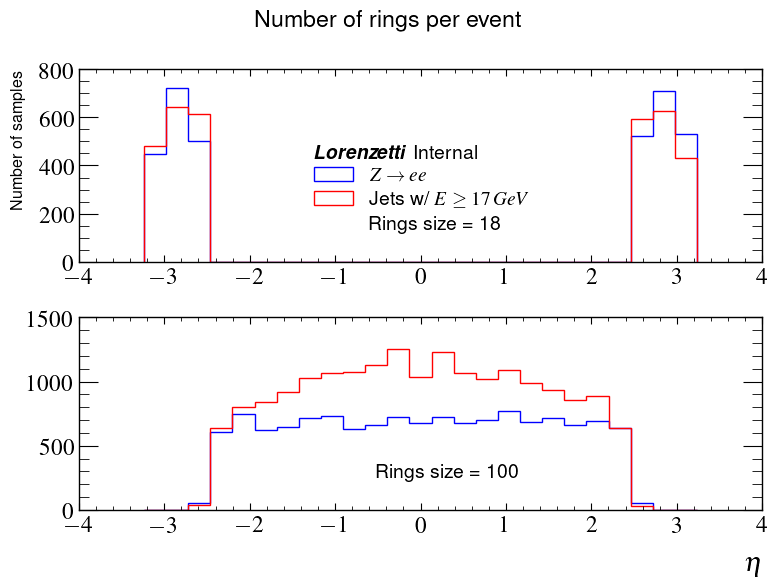

In [8]:
fig, axes = plt.subplots(2,1)
top_ax, lower_ax = axes
top_size = 18
lower_size = 100
for i, (name, dataset_info) in enumerate(datasets.items()):
    rings_info = dataset_info['rings_info']
    top_counts, top_bins, _ = top_ax.hist(
        rings_info.loc[rings_info['rings_size'] == top_size, 'cl_eta'],
        bins=25,
        histtype='step',
        color=dataset_info['color'],
        label=dataset_info['label'])
    # ax.grid(linestyle='--', alpha=0.5)
    if i == 1:
        top_ax.plot([], [], ' ',
                label=f'Rings size = {top_size}')
    top_ax.set_ylabel('Number of samples', fontsize='small')
    top_ax.legend(title='\\textbf{{\\textit{{Lorenzetti}}}} Internal',
                alignment='left',
                facecolor='white',
                ncols=1,
    )
    lower_ax.hist(
        rings_info.loc[rings_info['rings_size'] == lower_size, 'cl_eta'],
        bins=top_bins,
        histtype='step',
        color=dataset_info['color']
    )
    if i == 1:
        lower_ax.plot([], [], ' ',
                label=f'Rings size = {lower_size}')
    lower_ax.legend(alignment='left',
                facecolor='white',
                ncols=1,
    )
    lower_ax.set(
        xlabel='$\\eta$',
    )
fig.suptitle('Number of rings per event')
fig.tight_layout()
fig.savefig(output_dir / f'number_of_rings_multi_plot_{data_src}.png', dpi=300)

# Check $\mu \pm \sigma$

## Default

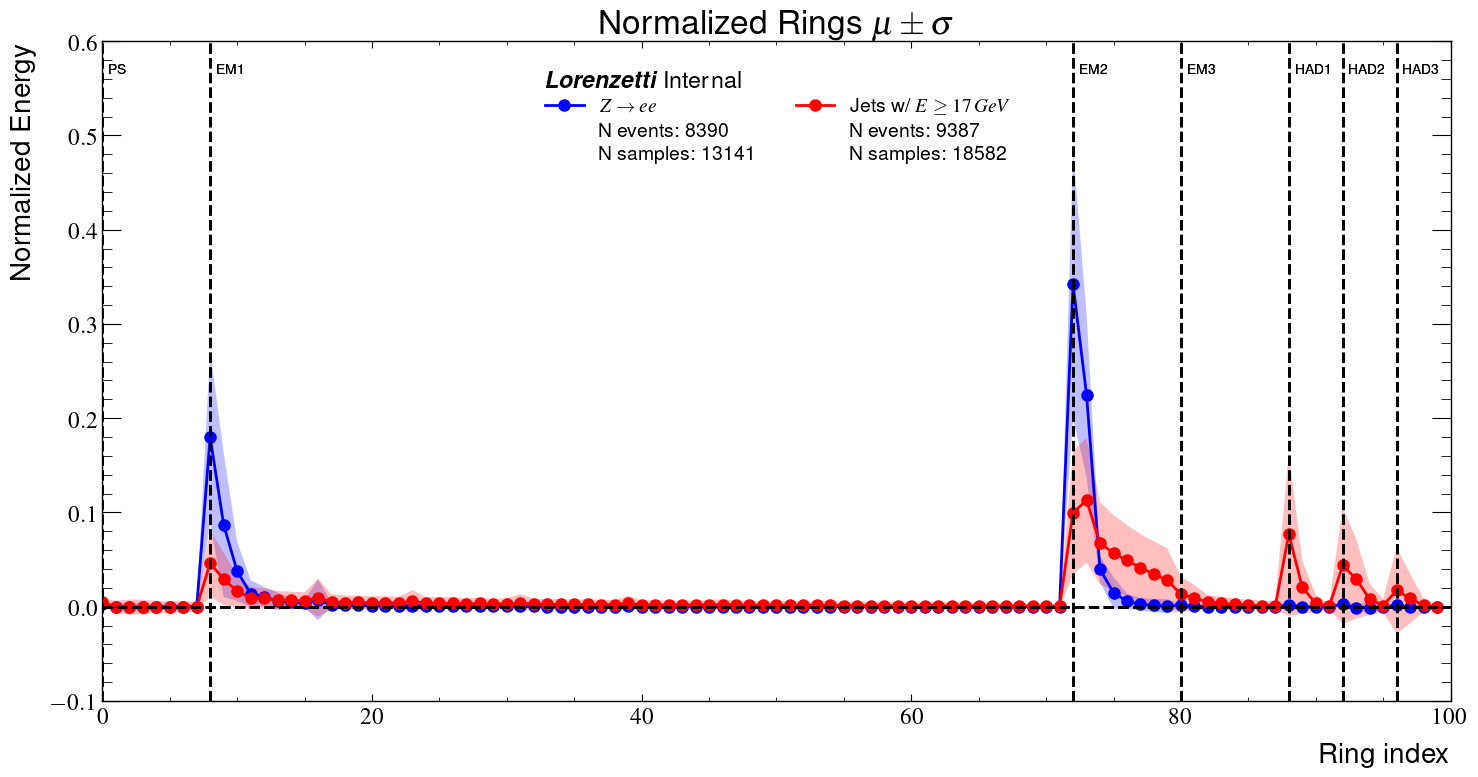

In [11]:
normalize=True
fig, ax = plt.subplots(figsize=(15, 8))
for name, dataset_info in datasets.items():
    rings_info = dataset_info['rings_info']
    rings_info = rings_info[rings_info['rings_size'] == N_RINGS]
    rings_columns = [f'ring_{i}' for i in range(rings_info.shape[-1]-4)]
    _ = lplt.plot_rings_profile(
        rings_info[rings_columns],
        ax=ax,
        normalize=normalize,
        color=dataset_info['color'],
        ax_set_kwargs=dict(
            ylabel='Normalized Energy' if normalize else 'Energy [MeV]',
        ),
        label=dataset_info['label']
    )
    ax.plot([], [], ' ',
        label=f'N events: {rings_info["event_number"].nunique()}')
    ax.plot([], [], ' ',
            label=f'N samples: {len(rings_info)}')
ax.legend(title='\\textbf{{\\textit{{Lorenzetti}}}} Internal',
          alignment='left',
          facecolor='white',
          ncols=len(datasets),
          title_fontproperties=dict(size='large'),
          )
fig.tight_layout()
if normalize:
    figname = f'mean_rings_normalized_{data_src}.png'
else:
    figname = f'mean_rings_{data_src}.png'
fig.savefig(output_dir / figname, dpi=300)

# All Rings

2025-05-02 14:35:07 | INFO | root | 4010992034 | 4 | Plotting rings for zee
2025-05-02 14:35:10 | INFO | root | 4010992034 | 4 | Plotting rings for jf17


/tmp/ipykernel_65458/4010992034.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()
/tmp/ipykernel_65458/4010992034.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(output_dir / figname, dpi=300)
/opt/lorenzetti-python/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/lorenzetti-python/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


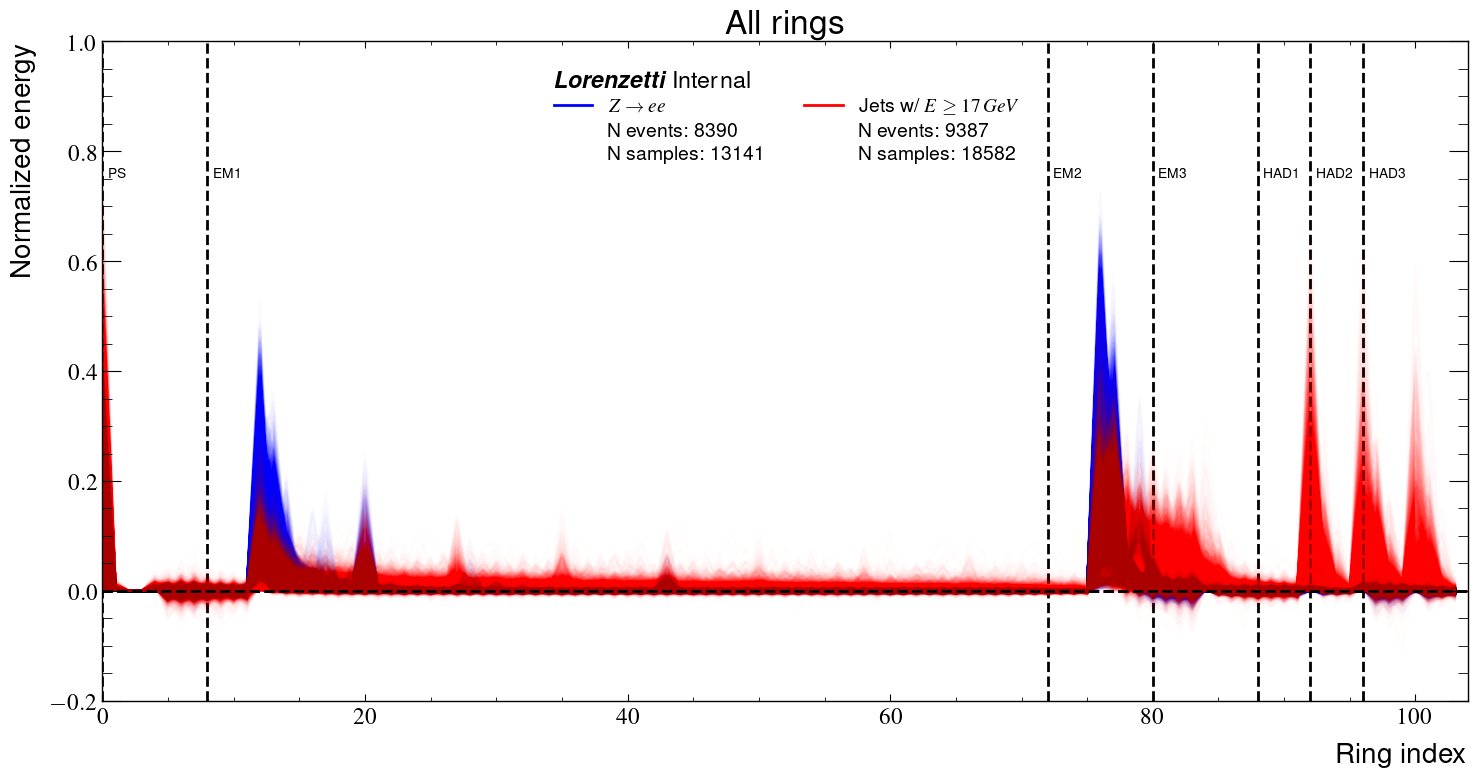

In [12]:
normalize=True
fig, ax = plt.subplots(figsize=(15, 8))
for i, (name, dataset_info) in enumerate(datasets.items()):
    logging.info(f'Plotting rings for {name}')
    x = np.arange(N_RINGS)
    rings_info = dataset_info['rings_info']
    rings_info = rings_info[rings_info['rings_size'] == N_RINGS]
    rings_columns = [f'ring_{i}' for i in range(rings_info.shape[-1]-2)]
    lplt.plot_all_rings(
        rings_info, ax,
        normalize=normalize,
        plot_kwargs=dict(
            color=dataset_info['color'],
            label=dataset_info['label'],
            alpha=0.01),
        add_rings_labels=(i==0))
    ax.plot([], [], ' ',
        label=f'N events: {rings_info["event_number"].nunique()}')
    ax.plot([], [], ' ',
            label=f'N samples: {len(rings_info)}')
    del rings_info
ax.legend(title='\\textbf{{\\textit{{Lorenzetti}}}} Internal',
          alignment='left',
          facecolor='white',
          ncols=len(datasets),
          title_fontproperties=dict(size='large'),
          )
fig.tight_layout()
if normalize:
    figname = f'all_rings_normalized_{data_src}_zee.png'
else:
    figname = f'all_rings_{data_src}.png'
fig.savefig(output_dir / figname, dpi=300)